In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import os
import random
import sys
from datetime import datetime

In [ ]:
%env --NotebookApp.iopub_data_rate_limit=1.0e10

env: --NotebookApp.iopub_data_rate_limit=1.0e10


# The MNIST Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train / 255.
x_test = x_test / 255.

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
y_train_one_hot = np.zeros((len(y_train), 10))
y_train_one_hot[np.arange(y_train.size), y_train] = 1

y_test_one_hot = np.zeros((len(y_test), 10))
y_test_one_hot[np.arange(y_test.size), y_test] = 1

y_train_one_hot = tf.constant(y_train_one_hot, dtype = tf.float32)
y_test_one_hot = tf.constant(y_test_one_hot, dtype = tf.float32)

In [ ]:
x_train = tf.reshape(tf.constant(x_train, dtype = tf.float32), [len(x_train), 28 * 28])
x_test = tf.reshape(tf.constant(x_test, dtype = tf.float32), [len(x_test), 28 * 28])

# Classifier based on categorical cross-entropy

In [ ]:
class KerasClassifer(tf.keras.Model):
    def __init__(self, **kwargs):
         super().__init__(**kwargs)
         self.m = tf.Variable(tf.zeros([784, 10]))
         self.b = tf.Variable(tf.zeros([10]))

    def call(self, img):
        return tf.linalg.matmul(img, self.m) + self.b

    def make_prediction(self, img):
        return tf.math.argmax(tf.linalg.matmul(img, self.m) + self.b)

def loss(predicted_one_hot, target_one_hot):
    return tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predicted_one_hot, labels=target_one_hot))

KerasModel = KerasClassifer()

batch_size = 50
epochs = 100

KerasModel.compile(optimizer='SGD', loss=loss, metrics=['accuracy', 'categorical_crossentropy'])
history = KerasModel.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs)

Epoch 1/100
1200/1200 [==============================] - 5s 3ms/step - loss: -12066.6348 - accuracy: 0.6674 - categorical_crossentropy: nan
Epoch 2/100
1200/1200 [==============================] - 3s 2ms/step - loss: -36220.6328 - accuracy: 0.6714 - categorical_crossentropy: 2.3155
Epoch 3/100
1200/1200 [==============================] - 3s 3ms/step - loss: -60374.5820 - accuracy: 0.6727 - categorical_crossentropy: 2.3154
Epoch 4/100
1200/1200 [==============================] - 3s 3ms/step - loss: -84528.5703 - accuracy: 0.6728 - categorical_crossentropy: 2.3154
Epoch 5/100
1200/1200 [==============================] - 4s 3ms/step - loss: -108682.6016 - accuracy: 0.6733 - categorical_crossentropy: 2.3154
Epoch 6/100
1200/1200 [==============================] - 4s 3ms/step - loss: -132836.5469 - accuracy: 0.6711 - categorical_crossentropy: 2.3154
Epoch 7/100
1200/1200 [==============================] - 3s 2ms/step - loss: -156990.5938 - accuracy: 0.6729 - categorical_crossentropy: 2.3154

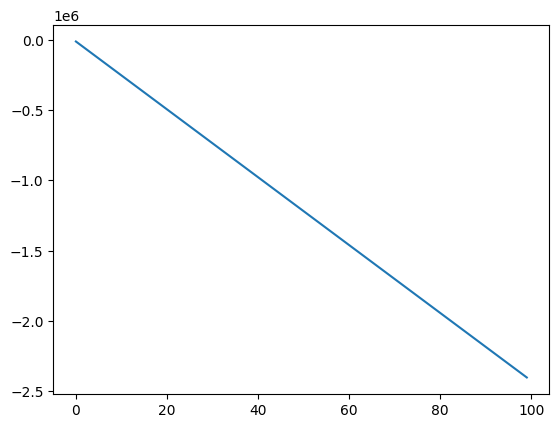

In [ ]:
plt.plot(history.history['loss'])
plt.show()

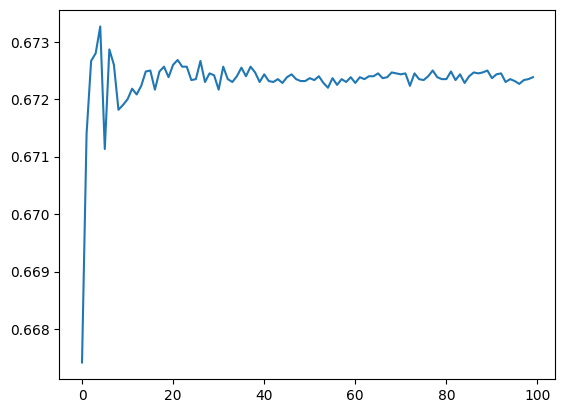

In [ ]:
# plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['accuracy'])

In [ ]:
print(x_test[1].shape)
tf.print("The predicted value is :", tf.math.argmax(tf.squeeze(KerasModel([x_test[1]]))))
tf.print("The actual value is : ", y_test[1])

(784,)
The predicted value is : 2
The actual value is :  2


In [ ]:
# The following code determines the accuracy of the model
invalid_indices = []

def TestValidity(i):
    if tf.math.argmax(tf.squeeze(KerasModel([x_test[i]]))) == y_test[i]:
        return True
    else:
        invalid_indices.append(i)
        return False

correct_guesses = 0

for x in range(10000):
    if TestValidity(x):
        correct_guesses += 1

print(f"The accuracy achieved by the model is {correct_guesses / 10000 * 100} %.")

The accuracy achieved by the model is 68.08999999999999 %.


In [ ]:
chkp_path = "DigitIdentification"
checkpoint = tf.train.Checkpoint(model=KerasModel)
checkpoint.write(chkp_path)

'DigitIdentification'

The model predicts that this digit is 6
The actual digit is 4


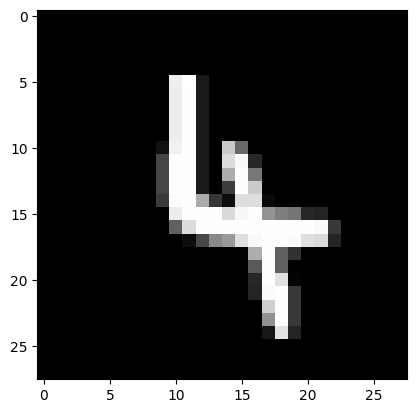

In [ ]:
def DisplayImage(i):
    tf.print("The model predicts that this digit is", tf.math.argmax(tf.squeeze(KerasModel([x_test[i]]))))
    tf.print("The actual digit is", y_test[i])
    img = x_test[i]
    img = tf.reshape(img, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()

DisplayImage(432)

# Vanilla Neural Network

## Manual

In [ ]:
class ImageClassifierNN(tf.Module):
    def __init__(self, layers, **kwargs): # The first element in layers is 28 * 28 and the last element is 10
        super().__init__(**kwargs)

        self.layers = layers

        # Create and initialise the data structure storing the weights and biases
        self.TotalWeightsAndBiases = 0
        for weight_set in range(len(self.layers) - 1):
            self.TotalWeightsAndBiases += self.layers[weight_set + 1] * self.layers[weight_set]
        self.TotalWeights = self.TotalWeightsAndBiases

        for bias_set in range(1, len(self.layers)):
            self.TotalWeightsAndBiases += self.layers[bias_set]

        self.WeightsAndBiases = tf.Variable(tf.zeros([self.TotalWeightsAndBiases]))

    @tf.function
    def __call__(self, img):
        temp_res = tf.reshape(img, [28 * 28, 1])
        WeightStartIndex = 0
        BiasStartIndex = self.TotalWeights
        for i in range(len(self.layers) - 1):
            op, ip = self.layers[i + 1], self.layers[i]
            weights = tf.reshape(self.WeightsAndBiases[WeightStartIndex : WeightStartIndex + op * ip] ,[op, ip])
            WeightStartIndex += op * ip
            biases = tf.reshape(self.WeightsAndBiases[BiasStartIndex : BiasStartIndex + op], [op, 1])
            temp_res = tf.math.sigmoid(tf.math.add(tf.linalg.matmul(weights,temp_res), biases))
        return temp_res

def MSELoss(predicted_y, target_y):
    return tf.reduce_mean(tf.square(target_y - predicted_y))

@tf.function
def train(ImgList, Target_yList, LossFunc, model, LearnRate, batch_size):
    img = ImgList[0]
    target_y = Target_yList[0]
    with tf.GradientTape() as t:
        y = model(img)
        loss = LossFunc(y, target_y)
    GradAvg = t.gradient(loss, model.WeightsAndBiases)
    i = 1
    while i < tf.shape(ImgList)[0]:
        img = ImgList[i]
        target_y = Target_yList[i]
        with tf.GradientTape() as t:
            y = model(img)
            loss = LossFunc(y, target_y)
        GradAvg = tf.math.add(t.gradient(loss, model.WeightsAndBiases), GradAvg) / 2 # This is not the optimum solution but is a solution that works to some degree
        i += 1

    model.WeightsAndBiases.assign_sub(GradAvg * LearnRate)

    return tf.math.reduce_mean(GradAvg)

def TrainingLoop(epochs, x_vars, y_vars, learning_rate, batch_size, model):
    gradients = []
    for epoch in range(epochs):
        for batch in range(int(len(x_vars) / batch_size)):
            print(f"Processing batch {batch} of epoch {epoch}")
            start = int(batch * batch_size)
            end = int((batch + 1) * batch_size)
            gradients.append(train(x_vars[start:end],
                                   y_vars[start:end],
                                   MSELoss,
                                   model,
                                   learning_rate,
                                   batch_size))
        print(f"Processed epoch {epoch}. Gradient = {gradients[-1]}")
    return gradients

In [ ]:
batch_size = 0.001 # Any random number that is not an integer
while batch_size != int(batch_size):
    batches_per_epoch = int(input("Enter the number of batches to be used: "))
    batch_size = len(x_train) / batches_per_epoch

learning_rate = 10
epochs = 1

NeuralNet = ImageClassifierNN([28 * 28, 30, 30, 10])

Enter the number of batches to be used: 10


In [ ]:
GradProgress = TrainingLoop(epochs, x_train, y_train_one_hot, learning_rate, batch_size, NeuralNet)

Processing batch 0 of epoch 0
Processing batch 1 of epoch 0
Processing batch 2 of epoch 0
Processing batch 3 of epoch 0
Processing batch 4 of epoch 0
Processing batch 5 of epoch 0
Processing batch 6 of epoch 0
Processing batch 7 of epoch 0
Processing batch 8 of epoch 0
Processing batch 9 of epoch 0
Processed epoch 0. Gradient = -1.938941807111405e-07


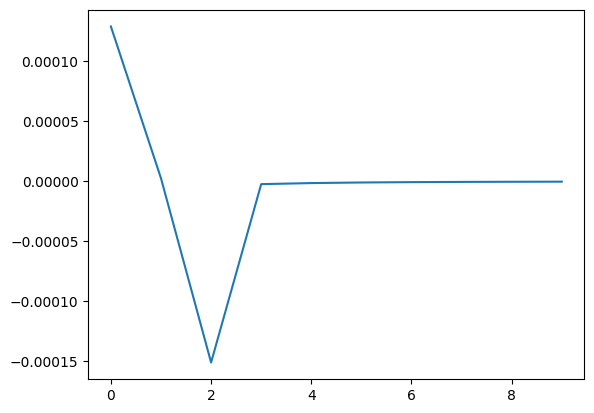

In [ ]:
plt.plot(GradProgress)
GradProgress = []

In [ ]:
# The following code determines the accuracy of the model
invalid_indices = []

def TestValidity(i):
    if tf.math.argmax(tf.squeeze(NeuralNet([x_test[i]]))) == y_test[i]:
        return True
    else:
        invalid_indices.append(i)
        return False

correct_guesses = 0

for x in range(10000):
    if TestValidity(x):
        correct_guesses += 1

print(f"The accuracy achieved by the model is {correct_guesses / 10000 * 100} %.")

The accuracy achieved by the model is 9.8 %.


The model predicts that this digit is 0
The actual digit is 9


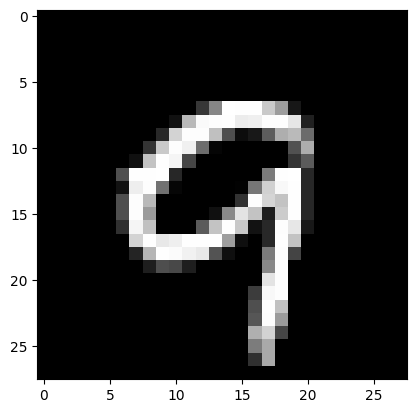

In [ ]:
def DisplayImage(i):
    tf.print("The model predicts that this digit is", tf.math.argmax(tf.squeeze(NeuralNet([x_test[i]]))))
    tf.print("The actual digit is", y_test[i])
    img = x_test[i]
    img = tf.reshape(img, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()

DisplayImage(1048)

## Using Keras

### Model subclassing

In [ ]:
tf.reshape(tf.repeat(tf.constant([1,2,3,4,5,6,7,8]), [5], axis=-1), [8,5])

<tf.Tensor: shape=(8, 5), dtype=int32, numpy=
array([[1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8]], dtype=int32)>

In [ ]:
class KerasSubclassedNetwork(tf.keras.Model):
    def __init__(self, layers, **kwargs): # The first element in layers is 28 * 28 and the last element is 10
        super().__init__(**kwargs)

        self.LayersArray = layers

        # Create and initialise the data structure storing the weights/ServiceLogin
        self.WeightsAndBiases = []
        for weight_set in range(len(self.LayersArray) - 1):
            self.WeightsAndBiases.append(tf.Variable(tf.zeros([self.LayersArray[weight_set + 1], self.LayersArray[weight_set]])))

        self.NumWeights = len(self.WeightsAndBiases)

        # Create and initalise the data structure for storing the biases
        for bias_set in range(1, len(self.LayersArray)):
            self.WeightsAndBiases.append(tf.Variable(tf.zeros([self.LayersArray[bias_set], 1])))

    @tf.function
    def call(self, img):
        batch_size = img.shape[0]
        layer_op = tf.transpose(img)
        for i in range(len(self.LayersArray) - 1):
            biases = tf.reshape(tf.repeat(self.WeightsAndBiases[self.NumWeights + i], batch_size), [self.LayersArray[i + 1], batch_size])
            layer_op = tf.nn.sigmoid(tf.math.add(tf.linalg.matmul(self.WeightsAndBiases[i], layer_op), biases))
        return tf.transpose(layer_op)

KerasNeuralNet = KerasSubclassedNetwork([28 * 28, 30, 30, 10])

KerasNeuralNet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1),
                    loss=tf.keras.losses.mean_squared_error,
                    metrics=['accuracy', 'MeanSquaredError'],
                    run_eagerly = True)
history = KerasNeuralNet.fit(x_train, y_train_one_hot, batch_size=6000, epochs=100)

Epoch 1/100
10/10 [==============================] - 2s 32ms/step - loss: 0.2104 - accuracy: 0.1104 - mean_squared_error: 0.2104
Epoch 2/100
10/10 [==============================] - 0s 31ms/step - loss: 0.1538 - accuracy: 0.1124 - mean_squared_error: 0.1538
Epoch 3/100
10/10 [==============================] - 0s 31ms/step - loss: 0.1267 - accuracy: 0.1124 - mean_squared_error: 0.1267
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 0.1129 - accuracy: 0.1124 - mean_squared_error: 0.1129
Epoch 5/100
10/10 [==============================] - 0s 30ms/step - loss: 0.1052 - accuracy: 0.1124 - mean_squared_error: 0.1052
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 0.1005 - accuracy: 0.1124 - mean_squared_error: 0.1005
Epoch 7/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0976 - accuracy: 0.1124 - mean_squared_error: 0.0976
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0956 - accuracy: 0.11

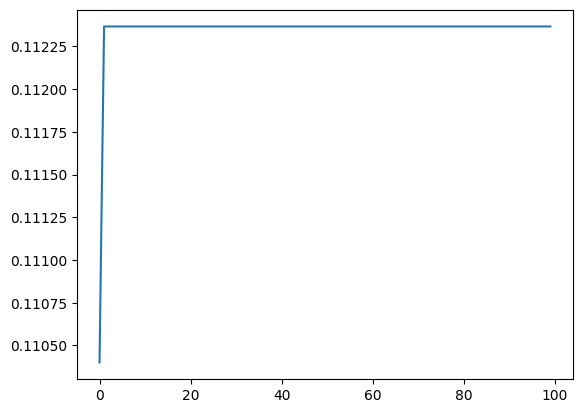

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
KerasNeuralNet.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 4s 12ms/step - loss: 0.0900 - accuracy: 0.1135 - mean_squared_error: 0.0900


[0.08996819704771042, 0.11349999904632568, 0.08996819704771042]

### Sequential API - the basics

In [ ]:
# Pass a list of layers to a sequential constructor
model = keras.Sequential(
    [layers.Dense(2, activation="relu"),
    layers.Dense(3, activation="relu"),
    layers.Dense(4)]
)

In [ ]:
model.layers # This returns a list

In [ ]:
model.pop()
print(len(model.layers))

2


In [ ]:
input = tf.ones([1,4])
y = model(input)
print("Number of weights after calling the model:", len(model.weights)) # This completes the model building

Number of weights after calling the model: 6


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (1, 2)                    10        
                                                                 
 dense_7 (Dense)             (1, 3)                    9         
                                                                 
 dense_8 (Dense)             (1, 4)                    16        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create the model incrementally using the add method
model = keras.Sequential()
model.add(keras.Input(shape=(4,))) # Adding an input like this is alternate way to build the model
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

In [ ]:
# The following code is identical to tbe above code
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu", input_shape=(4,)))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))



---



In [ ]:
initializer = tf.keras.initializers.GlorotNormal(seed=0)

model = keras.Sequential(
    [layers.Dense(30, activation="tanh", input_shape=(28 * 28,), kernel_initializer=initializer),
    layers.Dense(30, activation="tanh", kernel_initializer=initializer),
    layers.Dense(10, kernel_initializer=initializer)]
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.5),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy', 'mean_squared_error'])
history = model.fit(x_train, y_train_one_hot, batch_size=int(60000/10), epochs=10)

Epoch 1/10
10/10 [==============================] - 2s 12ms/step - loss: 11.9304 - accuracy: 0.0958 - mean_squared_error: 11.9304
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 3.0800 - accuracy: 0.1003 - mean_squared_error: 3.0800
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 1.1722 - accuracy: 0.1021 - mean_squared_error: 1.1722
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.5030 - accuracy: 0.1012 - mean_squared_error: 0.5030
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2352 - accuracy: 0.0994 - mean_squared_error: 0.2352
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1453 - accuracy: 0.1004 - mean_squared_error: 0.1453
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.1107 - accuracy: 0.0976 - mean_squared_error: 0.1107
Epoch 8/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0981 - accuracy: 0.0995 - m

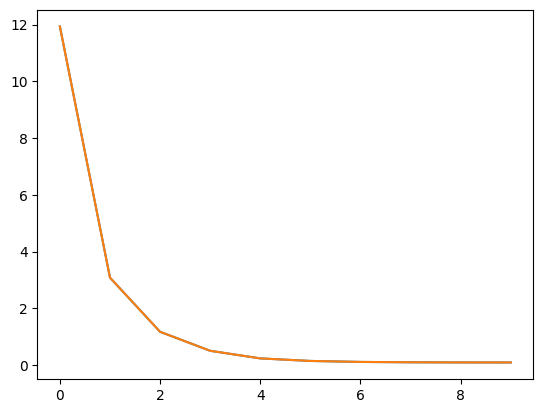

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_squared_error'])
plt.show()

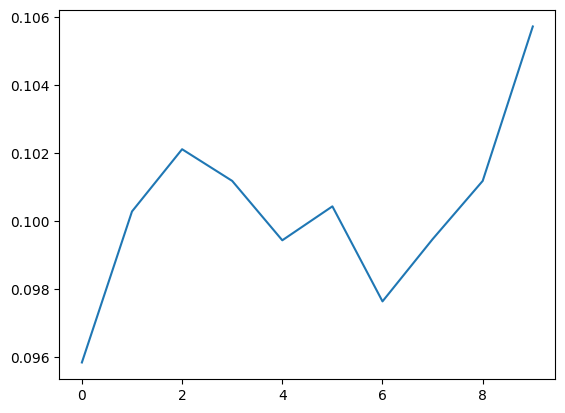

In [ ]:
plt.plot(history.history['accuracy'])
plt.show()

In [ ]:
# The following code determines the accuracy of the model
invalid_indices = []

# This function is excessive when using Keras
def TestValidity(i):
    if tf.math.argmax(tf.squeeze(model(tf.reshape(x_test[i], [1, 28 * 28])))) == y_test[i]:
        return True
    else:
        invalid_indices.append(i)
        return False

# This is more efficient
def TestValidityKeras(model, x, y):
    return int(tf.math.count_nonzero( tf.math.argmax(model(x), axis = -1) - tf.math.argmax(y, axis = -1) ))

tf.print("The error rate is", TestValidityKeras(model, x_test, y_test_one_hot) / 10000 * 100, "%.")

The error rate is 90.42 %.


In [ ]:
model.evaluate(x_test, y_test_one_hot)[1] * 100 # This function returns the loss, accuracy and MSE

313/313 [==============================] - 1s 3ms/step - loss: 0.0905 - accuracy: 0.0958 - mean_squared_error: 0.0905


9.57999974489212

### Functional API

In [ ]:
inputs = keras.Input(shape=(784,))
dense = layers.Dense(64, activation="sigmoid") # Creates a new layer
x = dense(inputs) # Creates the connection to this layer
x = layers.Dense(64, activation="sigmoid")(x)
outputs = layers.Dense(10, activation="softmax")(x)

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model") # This creates the graph of the model

In [ ]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


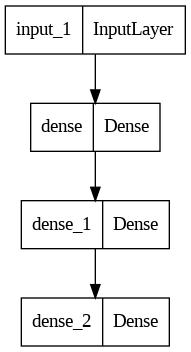

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

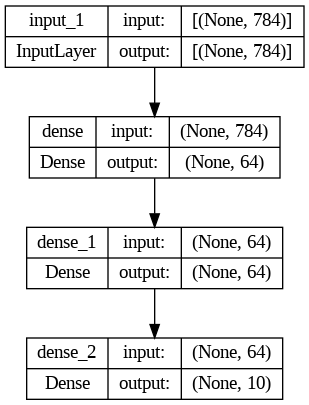

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy', 'MeanSquaredError']
)
history = model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6000/6000 [==============================] - 33s 5ms/step - loss: 0.5065 - accuracy: 0.8548 - mean_squared_error: 27.3682
Epoch 2/10
6000/6000 [==============================] - 16s 3ms/step - loss: 0.3016 - accuracy: 0.9106 - mean_squared_error: 27.3835
Epoch 3/10
6000/6000 [==============================] - 16s 3ms/step - loss: 0.2801 - accuracy: 0.9171 - mean_squared_error: 27.3850
Epoch 4/10
6000/6000 [==============================] - 21s 4ms/step - loss: 0.2663 - accuracy: 0.9215 - mean_squared_error: 27.3858
Epoch 5/10
6000/6000 [==============================] - 21s 3ms/step - loss: 0.2563 - accuracy: 0.9252 - mean_squared_error: 27.3864
Epoch 6/10
6000/6000 [==============================] - 16s 3ms/step - loss: 0.2465 - accuracy: 0.9281 - mean_squared_error: 27.3868
Epoch 7/10
6000/6000 [==============================] - 23s 4ms/step - loss: 0.2471 - accuracy: 0.9284 - mean_squared_error: 27.3870
Epoch 8/10
6000/6000 [==============================] - 16s 3ms/step - loss: 0.2

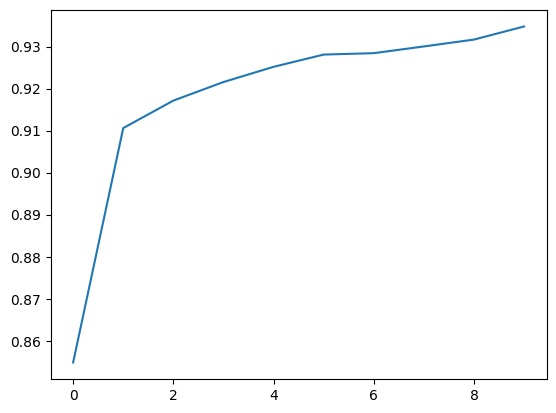

In [ ]:
plt.plot(history.history['accuracy'])

The recorded accuracy is 93.47666501998901 %
The model predicts that this digit is 4
The actual digit is 4


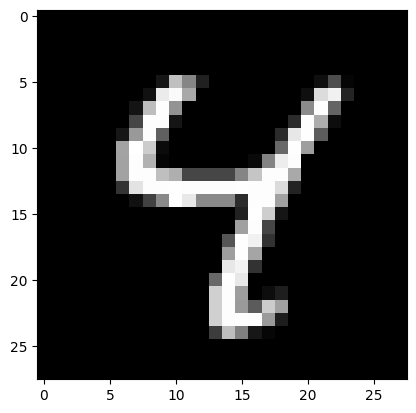

In [ ]:
print(f"The recorded accuracy is {history.history['accuracy'][-1] * 100} %")

def DisplayImage(i):
    tf.print("The model predicts that this digit is", tf.argmax(tf.squeeze(model(tf.reshape(x_test[i], [1, 784])))))
    tf.print("The actual digit is", y_test[i])
    img = x_test[i]
    img = tf.reshape(img, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()

DisplayImage(6)

# Convolution Neural Networks

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 8s 0us/step


In [ ]:
x_train = tf.constant(x_train, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.float32)

In [ ]:
keep_prob = 0.6
num_filters = 32
filter_size = 5
learning_rate = 0.0005

model = keras.Sequential(
    [layers.Rescaling(1./255), # This help in the training of the neural network; it is best if input values are small
     layers.Conv2D(num_filters, filter_size, padding='same', activation = tf.nn.relu,),
     layers.Dropout(keep_prob),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Conv2D(num_filters, filter_size, padding='same', activation = tf.nn.relu),
     layers.Dropout(keep_prob),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Conv2D(num_filters, filter_size, padding='same', activation = tf.nn.relu),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Conv2D(num_filters, filter_size, padding='same', activation = tf.nn.relu),
     layers.Dropout(keep_prob),
     tf.keras.layers.Flatten()]
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
5000/5000 [==============================] - 38s 4ms/step - loss: 6.2708 - accuracy: 0.0999
Epoch 2/10
5000/5000 [==============================] - 23s 5ms/step - loss: 6.2385 - accuracy: 0.1000
Epoch 3/10
5000/5000 [==============================] - 24s 5ms/step - loss: 6.2404 - accuracy: 0.1000
Epoch 4/10
5000/5000 [==============================] - 35s 7ms/step - loss: 6.2385 - accuracy: 0.1000
Epoch 5/10
5000/5000 [==============================] - 23s 5ms/step - loss: 6.2385 - accuracy: 0.1000
Epoch 6/10
5000/5000 [==============================] - 23s 5ms/step - loss: 6.2385 - accuracy: 0.1000
Epoch 7/10
5000/5000 [==============================] - 22s 4ms/step - loss: 6.2385 - accuracy: 0.1000
Epoch 8/10
5000/5000 [==============================] - 24s 5ms/step - loss: 6.2385 - accuracy: 0.1000
Epoch 9/10
5000/5000 [==============================] - 22s 4ms/step - loss: 6.2385 - accuracy: 0.1000
Epoch 10/10
5000/5000 [==============================] - 22s 4ms/step - l

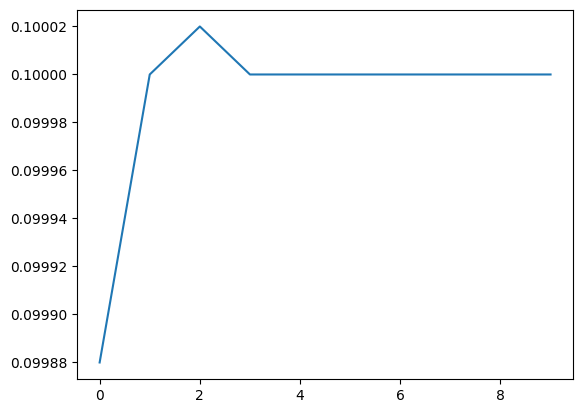

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 6.2383 - accuracy: 0.1000


[6.238307476043701, 0.10000000149011612]

# RNNs

In [ ]:
from timeit import default_timer as timer

## Basics RNNs

In [ ]:
ACCURACY_THRESHOLD = 0.90

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
RNNmodel = keras.Sequential()

inputs = keras.Input(shape=(None,32,32))
RNNmodel.add(layers.SimpleRNN(20))
RNNmodel.add(layers.BatchNormalization())
RNNmodel.add(layers.Dense(20))
RNNmodel.add(layers.Dense(10))

RNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy', 'mean_squared_error'])

start = timer()
history = RNNmodel.fit(x_train, y_train_one_hot, batch_size=int(60000/10), epochs=100, callbacks=[callbacks])
end = timer()
duration = end - start
print(f"The execution took {duration}s.")

Epoch 1/100
10/10 [==============================] - 2s 22ms/step - loss: 0.3305 - accuracy: 0.1887 - mean_squared_error: 0.3305
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0970 - accuracy: 0.1912 - mean_squared_error: 0.0970
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0855 - accuracy: 0.3151 - mean_squared_error: 0.0855
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0813 - accuracy: 0.3550 - mean_squared_error: 0.0813
Epoch 5/100
10/10 [==============================] - 0s 36ms/step - loss: 0.0782 - accuracy: 0.3936 - mean_squared_error: 0.0782
Epoch 6/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0758 - accuracy: 0.4265 - mean_squared_error: 0.0758
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0737 - accuracy: 0.4448 - mean_squared_error: 0.0737
Epoch 8/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0720 - accuracy: 0.45

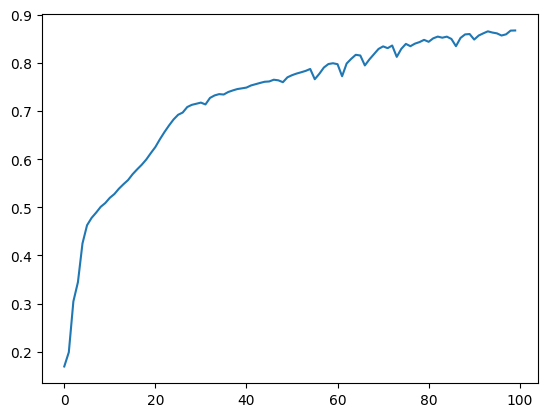

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
RNNmodel.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 2s 3ms/step - loss: 0.0366 - accuracy: 0.8606 - mean_squared_error: 0.0366


[0.036560170352458954, 0.8605999946594238, 0.036560170352458954]

## Stacked RNN cells

In [ ]:
StackedRNNmodel = keras.Sequential()

inputs = tf.keras.layers.Input(shape=[None, 32, 32])

rnn_cells = [tf.keras.layers.SimpleRNNCell(20) for _ in range(3)]
stacked_RNN = tf.keras.layers.StackedRNNCells(rnn_cells)

StackedRNNmodel.add(tf.keras.layers.RNN(stacked_RNN))
StackedRNNmodel.add(layers.BatchNormalization())
StackedRNNmodel.add(layers.Dense(20))
StackedRNNmodel.add(layers.Dense(10))

Epoch 1/100
10/10 [==============================] - 5s 32ms/step - loss: 0.3354 - accuracy: 0.1268 - mean_squared_error: 0.3354
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 0.0994 - accuracy: 0.2080 - mean_squared_error: 0.0994
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0889 - accuracy: 0.2419 - mean_squared_error: 0.0889
Epoch 4/100
10/10 [==============================] - 0s 32ms/step - loss: 0.0850 - accuracy: 0.2441 - mean_squared_error: 0.0850
Epoch 5/100
10/10 [==============================] - 0s 32ms/step - loss: 0.0826 - accuracy: 0.2535 - mean_squared_error: 0.0826
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0809 - accuracy: 0.2822 - mean_squared_error: 0.0809
Epoch 7/100
10/10 [==============================] - 0s 32ms/step - loss: 0.0799 - accuracy: 0.2916 - mean_squared_error: 0.0799
Epoch 8/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0792 - accuracy: 0.27

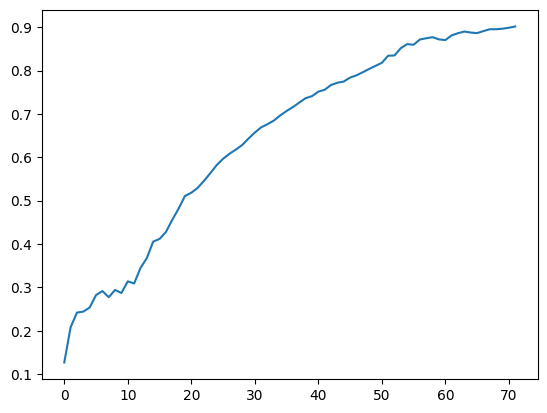

In [ ]:
StackedRNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy', 'mean_squared_error'])

start = timer()
history = StackedRNNmodel.fit(x_train, y_train_one_hot, batch_size=int(60000/10), epochs=100, callbacks=[callbacks])
end = timer()
duration = end - start
print(f"The execution took {duration}s.")

plt.plot(history.history['accuracy'])
plt.show()

## Sliding windows

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.6 MB/s eta 0:00:00


In [ ]:
import tensorflow_text as tf_text

t1 = tf.constant([1,2,3,4,5,6,7,8,9,10])
tf_text.sliding_window(t1, width=2, axis=-1)

<tf.Tensor: shape=(9, 2), dtype=int32, numpy=
array([[ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10]], dtype=int32)>

# Wide and deep models

In [ ]:
linear_model = tf.keras.experimental.LinearModel()

dnn_model = tf.keras.Sequential([keras.layers.Dense(30, activation='sigmoid'),
                                 keras.layers.Dense(30, activation='sigmoid'),
                                 keras.layers.Dense(1)])

combined_model = tf.keras.experimental.WideDeepModel(linear_model, dnn_model)

combined_model.compile(optimizer=['sgd', 'adam'],
                       loss='mse', metrics=['accuracy', 'mse'])
combined_model.fit([x_train, x_train], y_train, batch_size = 100, epochs = 10)

Epoch 1/10
600/600 [==============================] - 3s 3ms/step - loss: 3.7162 - accuracy: 0.1374 - mse: 3.7162
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 2.3276 - accuracy: 0.1525 - mse: 2.3276
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 1.5253 - accuracy: 0.1718 - mse: 1.5253
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 1.1971 - accuracy: 0.1808 - mse: 1.1971
Epoch 5/10
600/600 [==============================] - 3s 4ms/step - loss: 1.0335 - accuracy: 0.1834 - mse: 1.0335
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.9282 - accuracy: 0.1845 - mse: 0.9282
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.8590 - accuracy: 0.1852 - mse: 0.8590
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.8090 - accuracy: 0.1867 - mse: 0.8090
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.7698 - accur

In [ ]:
combined_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8192 - accuracy: 0.1899 - mse: 0.8192


[0.8191579580307007, 0.1898999959230423, 0.8191579580307007]

In [ ]:
# The following code determines the accuracy of the model
invalid_indices = []

def TestValidity(i):
    if int(tf.squeeze(combined_model.predict(tf.reshape(x_test[i], [1, 28 * 28])))) == y_test[i]:
        return True
    else:
        invalid_indices.append(i)
        return False

correct_guesses = 0

for x in range(10000):
    if TestValidity(x):
        correct_guesses += 1

print(f"The accuracy achieved by the model is {correct_guesses / 10000 * 100} %.")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step
The model predicts that this digit is 4
The actual digit is 4


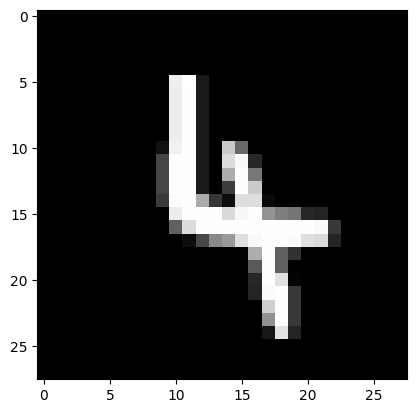

In [ ]:
def DisplayImage(i):
    tf.print("The model predicts that this digit is", int(tf.squeeze(combined_model.predict(tf.reshape(x_test[i], [1, 28 * 28])))))
    tf.print("The actual digit is", y_test[i])
    img = x_test[i]
    img = tf.reshape(img, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()

DisplayImage(432)